In [32]:
import json
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
import torch
import torchvision.transforms as T

parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.image_handling import crop_image, pad_bbox
from utils.keypoints import crop_and_resize_keypoints
from utils.heatmap import generate_multi_gaussian_heatmaps, decode_heatmaps
from training.keypointnet import KeypointNet

In [33]:
BASE_PATH = Path("../../")

In [34]:
def load_sample(sample_path):
    with open(sample_path, 'r') as f:
        samples = json.load(f)
    return samples

In [35]:
def preprocess_image(image_path, bbox, target_size=(128,128)):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = crop_image(img, bbox)
    resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_LINEAR)
    resized_img = T.ToTensor()(resized_img)
    return resized_img.unsqueeze(0)

In [47]:
def visualize_model_quality(obj_id, samples):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_KEYPOINTS = 15
    IMAGE_SIZE =(128, 128)
    MODEL_PATH = BASE_PATH / f"models/r6dnet/obj_{obj_id:06d}.pt"
    model = KeypointNet(
        num_keypoints=NUM_KEYPOINTS,
        output_size=IMAGE_SIZE,
    ).to(device)

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()

    fig, axes = plt.subplots(2, len(samples), figsize=(5 * len(samples), 10))

    if len(samples) == 1:
        axes = [axes]

    for i, sample_entry in enumerate(samples):
        image_id = sample_entry['image_id']
        bbox =  pad_bbox(sample_entry['bbox_obj'])
        keypoints = sample_entry['keypoints_2D']   
        image_path = BASE_PATH / sample_entry['rgb_path']
        gt_keypoints = crop_and_resize_keypoints(keypoints, bbox, IMAGE_SIZE)
        gt_heatmaps = generate_multi_gaussian_heatmaps(gt_keypoints, *IMAGE_SIZE, sigma=5)
        img = preprocess_image(image_path, bbox).to(device)

        with torch.no_grad():
            heatmaps = model(img)
            heatmaps_np = heatmaps.cpu().numpy()[0]
            decoded_keypoints = decode_heatmaps(heatmaps_np)

        axes[0][i].imshow(img.cpu().numpy()[0].transpose(1, 2, 0))
        axes[0, i].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='red', label='GT', s=50, marker='x')
        axes[0][i].set_title(f"Sample {image_id}")
        axes[0][i].axis('off')

        axes[1, i].imshow(heatmaps_np.sum(axis=0), cmap='jet')
        axes[1, i].scatter(decoded_keypoints[:, 0], decoded_keypoints[:, 1], c='red', label='Decoded', s=30, marker='o')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

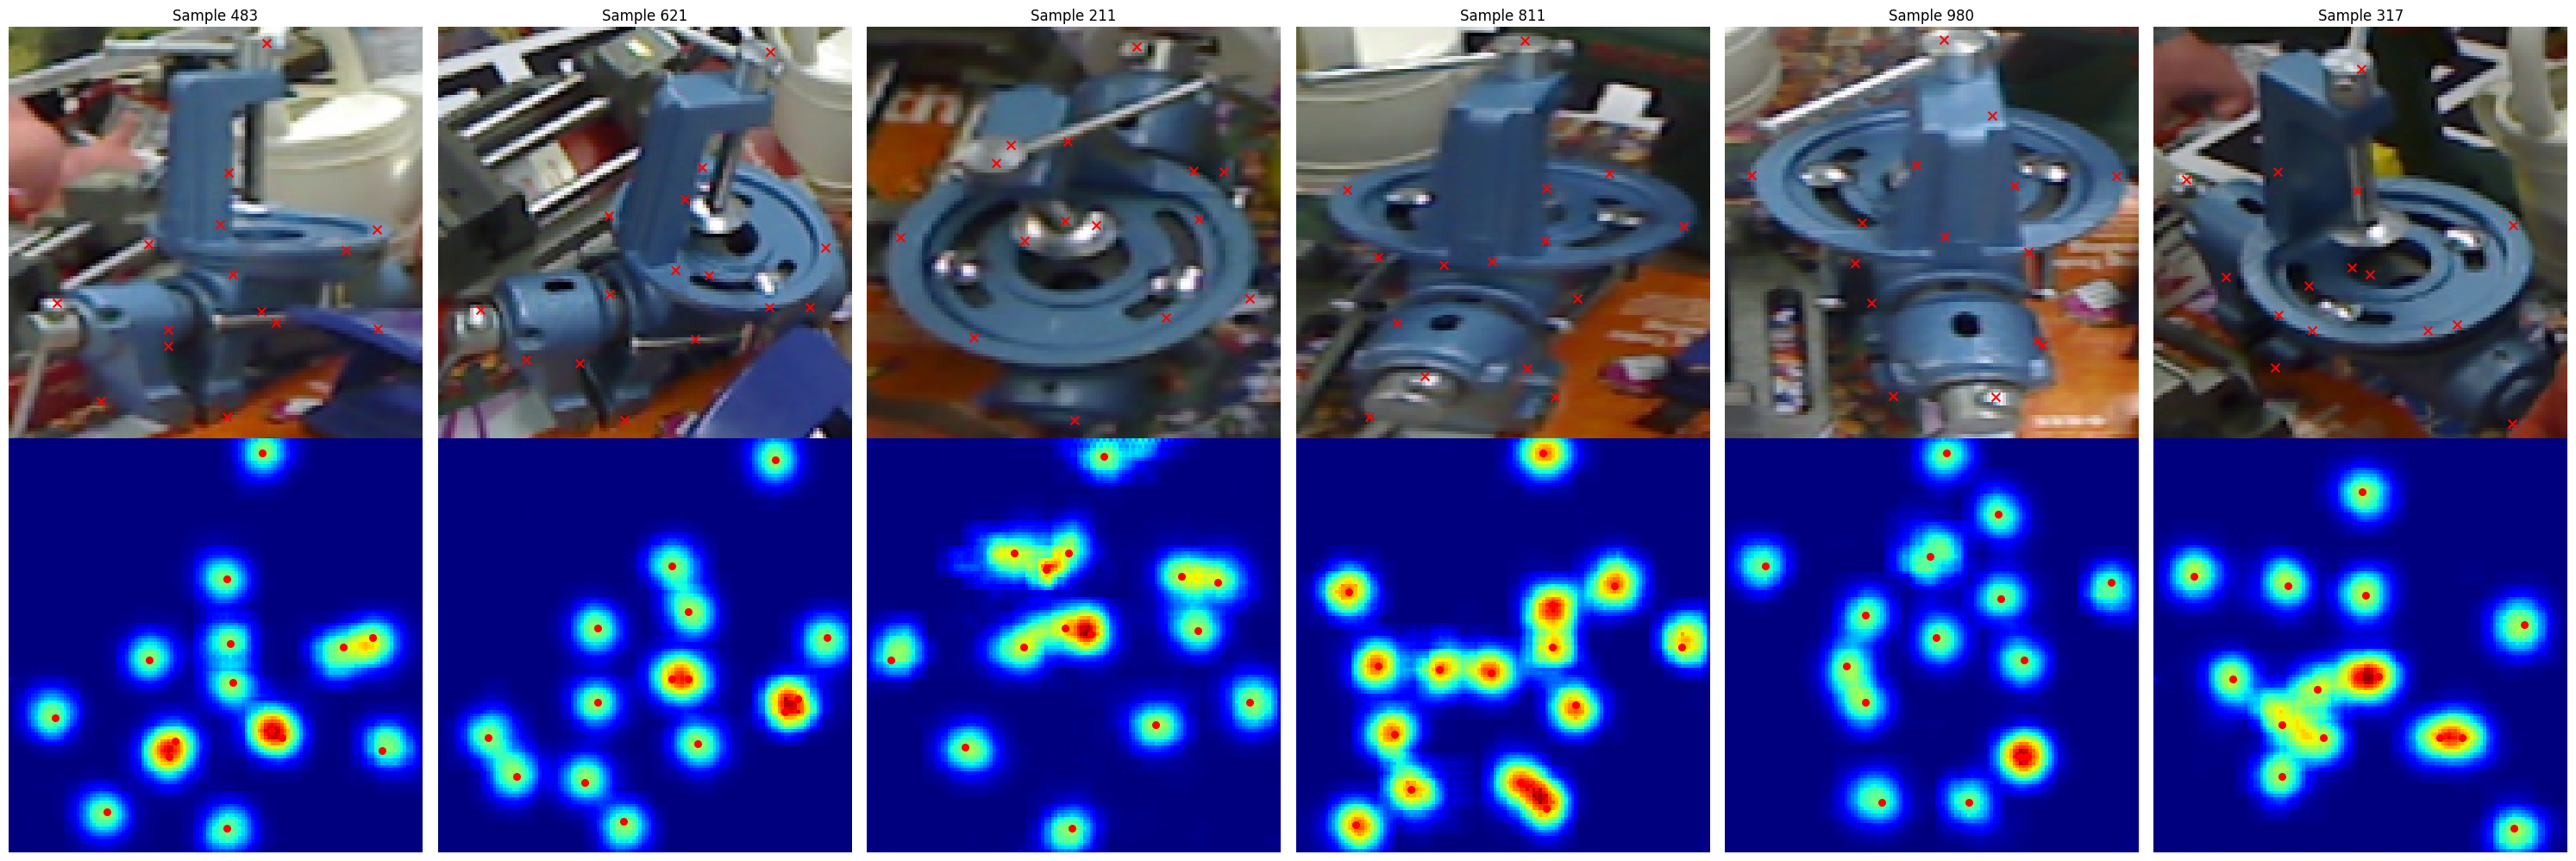

In [48]:
obj_id = 2  # Change as needed
sample_path = BASE_PATH / f"data/annotations/test/{obj_id:06d}.json"
samples = load_sample(sample_path)

# Randomly select 3 samples
random.seed(4)
selected_samples = random.sample(samples, 6)
visualize_model_quality(obj_id, selected_samples)